**Team members**:
- ...
- ...

# Machine Learning in Healthcare 2022-2023: Neural ODEs

**General Instructions**:

- The lab is mean to be carried out **in pairs**.
- This notebook is the only thing you are expected to hand in.
    - You must do it through the [corresponding task in *Aula Global*](https://aulaglobal.uc3m.es/mod/assign/view.php?id=4243786).
    - Running the notebook should allow to *roughly* (up the variability induced by the use of random numbers) reproduce the results saved in the notebook.
- You should hand in your work 2 weeks after the second session, i.e., the **deadline is December the 16th at 23:59**.
- It is enough if one of the partners hands in the assignment as long as both members of the team appear in the cell above.

**The task at hand**:

- Follow the logic of the notebook filling in the missing `# your code` bits.
- At the end, you are asked to perform a few extra experiments. They are meant to involve minor tweaks in the code.
    - The answer to every question must be entered in the corresponding empty cell bellow.

## Setup

This section will make sure we have all the required software installed. You can safely skip it.

First of all, let us find out if we are in [Colab](https://colab.research.google.com/)

In [ ]:
import sys
in_colab = 'google.colab' in sys.modules
in_colab

If so, we only need to install a couple of libraries

In [ ]:
if in_colab:
    !pip install torchdiffeq
    !pip install git+https://github.com/manuvazquez/uc3m_ml_healthcare@main

*Matplotlib* plots are to be embedded in the notebook

In [ ]:
%matplotlib inline

Let us import some of the libraries we will be using down below

In [ ]:
import numpy as np
import torch
from torch import nn
import torchdiffeq
import seaborn as sns
import matplotlib.pyplot as plt

## Neural ODEs for Time Series

The goal of this lab is to *learn* a function (implemented as a Neural Network) able to predict (extrapolate) the future behaviour of a time series given a bunch of measurements thereof. In the figure below, assume that you are given the <font color='blue'>blue points</font> and your task is to predict how the series will continue at the <font color='red'>red points</font> by modeling the unknown dynamics governing the system. As an exaple, the <font color='green'>green line</font> is a $3^{rd}$-degree
polynomial fit (on just the blue points).

In [ ]:
from uc3m_ml_healthcare import plot

t = torch.tensor([0, 0.2, 0.7, 0.9, 1.3, 1.5])
y = torch.tensor([0.4, 0.8, 0.25, 0.2, 0.25, 0.32])
observed_t, observed_y, to_predict_at_t, to_predict_y = t[:-2], y[:-2], t[-2:], y[-2:]
axis = plot.partially_observed_time_series(observed_t, observed_y, to_predict_at_t)

# polynomial fitting
poly = np.polynomial.polynomial.Polynomial.fit(observed_t, observed_y, deg=3)

# the "learned" polynomial is used on every time instant
poly_y = poly(t)

sns.lineplot(x=t, y=poly_y, color='green', linestyle='dashed', ax=axis)
sns.scatterplot(x=to_predict_at_t, y=to_predict_y, color='red');

You could do better using more sophisticated approaches, but in any case notice we are trying to predict *out-of-domain*, i.e., on regions of the input which were never seen during training. Also, in this example we have *scalar* observations but we might have to deal with vectors.

We aim at implementing a *simplified* (but equally performant) version the model for `periodic` dataset proposed in [Latent ODEs for Irregularly-Sampled Time Series](https://arxiv.org/abs/1907.03907).

## Data

Let us use the code in `uc3m_ml_healthcare.data`...

In [ ]:
from uc3m_ml_healthcare import data

...to generate some synthetic data. Specifically, we will make 1000 time series, each one with 100 *scalar* observations. All the series share a common (uniformly random) time axis, and are contaminated by Gaussian noise with zero mean and standard deviation 0.01.

In [ ]:
time, observations = data.make_periodic_dataset(
    timepoints=100,
    extrap=False,
    max_t=5.,
    n=1_000,
    noise_weight=0.01
)

Check the dimensions of both `time` and `observations` tensors and think about the interpretation of every dimension

In [ ]:
# your code (~2 LOC)
# ...

Plot together a few time series

In [ ]:
# your code (~1-2 LOC)
# ...

Split the `observations` (`time` stays the same) in *training* and *validation* sets. Keep 20% of the data for validation.

You don't have to use the suggested names (here, `train_obs` and `valid_obs`), but if you do, some *safety* checks will be performed for you along the way. **If you want to use other names, adjust or or delete all the `assert`s and referencing code**.

In [ ]:
# your code (~4 LOC)
# ...
# train_obs = 
# valid_obs = 

In [ ]:
assert observations.shape[1:] == train_obs.shape[1:] == valid_obs.shape[1:],\
'Training and validation tensor\'s dimension should only differ from that of the original observations in the first dimension'

For every time series, we are going to simulate the above <font color='blue'>blue</font> vs <font color='red'>red</font> points situation: the first **half** of the series is <font color='blue'>observed</font> and will be used for training, while the second one is to be <font color='red'>predicted</font> (given the corresponding time instants) based on the learned model. Hence, we will break down every time series into four variables
- time instants associated with the observations (**x**-coordinates for the <font color='blue'>blue</font> points above),
- observations (**y**-coordinates for the <font color='blue'>blue</font> points above),
- time instants at which we want to predict (**x**-coordinates for the <font color='red'>red</font> points above), and
- values to be predicted (**y**-coordinates for the <font color='red'>blue</font> points above)

### Loaders

The `data` module in `uc3m_ml_healthcare` provides a *collate function* to be employed with a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) that does this on the fly.

In [ ]:
collate_fn = data.CollateFunction(time)
collate_fn

Build `DataLoader`s for both the training and validation datasets with a *batch size* of 64 examples, and using the above *collate function*. The `dataset` to be used when instantiating `torch.utils.data.DataLoader` is simply the observations, the `time` information being taken care of by the *collate function* (you can think of it as a fixed parameter embedded in the latter).

In [ ]:
# your code (~3 LOC)
# ...
# train_dataloader = 
# valid_dataloader =

Let us request a batch a take a look at what is returned

In [ ]:
batch = next(iter(train_dataloader))
type(batch)

The above *collate function* packs a batch into a dictionary with the following fields

In [ ]:
batch.keys()

The four first fields correspond with the above-mentioned four variables into which we are going to decompose a time series. We will be ignoring the last one, `observed_mask`, in this lab. Check the shapes of the fields and make sure you know how to interpret every dimension

In [ ]:
for k, v in batch.items():
    print(f'{k}: {v.shape}')

## Model

We will be building an encoder-decoder architecture. For every time series, we will *encode* (summarize) the <font color='blue'>observations</font> to get a vector, $\mathbf{z}_0$ (in a latent space) that will completely determine (in *decoding*) the <font color='red'>values</font> to be predicted (at the given time instants). Hence, the full model will encompass a *recognizer*, the encoder, and a *generator* (the decoder). Both *modules* will use an ODE solver for propagating a latent state. We don't need to implement this ourselves as this is provided by [torchdiffeq](https://github.com/rtqichen/torchdiffeq)'s `odeint` function

In [ ]:
torchdiffeq.odeint

As can be seen from the prototype of the function, we need to pass at least three arguments to `odeint`:
- the function defining the ODE, i.e., the $f$ in 
$$\frac{dy}{dt} = f(t,y),$$
- the initial value, $y_0$, and
- a sequence of time instants, $t_0, t_1, t_2\cdots$ at which we want the solution of the ODE, $y_1, y_2, \cdots$

Let's give a try!!

We make up a simple function, `f`, an initial value, `y0`, and some time instants, `t`, at which we would like to *approximate* the value of $y$. Notice how we encapsulate everything in `torch.tensor` since `torchdiffeq` is meant to be used with *PyTorch*.

In [ ]:
f = lambda t, y : 2*t
y0 = torch.tensor(0.)
t = torch.tensor([0.1, 0.5, 1., 2.])

Let us numerically integrate the differential equation using `odeint`

In [ ]:
y = torchdiffeq.odeint(f, y0, t)

What would you expect to see in plotting `y`? Double check by plotting it.

In [ ]:
# your code (~3 LOC)
# ...

Notice that `odeint` expects a function (`f` above) receiving two arguments: the time, and the value of the function. Hence, never mind that your modeling function doesn't need time (it won't), you **always have to pass a function (a NN) that accepts a time instant as the first argument, and the value of the function as the second**.

For the sake of convenience we are going to make a *custom* PyTorch `Module` that will *wrap* around a given NN and numerically integrates it using `odeint`

In [ ]:
class ODESolver(torch.nn.Module):
    "A thin wrapper around torchdiffeq's `odeint`"
    
    def __init__(self,
                 f: torch.nn.Module, # Function determining the derivative
                 method: str = 'dopri5'
                ):
        
        super().__init__()
        
        self.f = f
        self.method = method
        
    def forward(self,
                y0: torch.Tensor, # Initial value
                t: torch.Tensor # Time instants at which to compute the solution (the first one is assumed to correspond with y0)
               ):
        
        return torchdiffeq.odeint(self.f, y0, t, rtol=1e-4, atol=1e-5, method=self.method)

The above code gives you the essence of how to define a custom PyTorch `Module`: you make a class
- inheriting from `torch.nn.Module`,
- you define the `__init__` method as you like, but taking care of *always* call `super().__init__()` (otherwise, you don't get PyTorch's magic), and
- you define the `forward` method, which determines the operation of the `Module`.

Once we have instantiated the solver with the function of interest...

In [ ]:
solver = ODESolver(f)

...we can do just as above (without the need to pass in the function at every call)

In [ ]:
solver(y0, t)

### Recognizer

The recognizer is going to encompass 4 different (interconnected) `torch.nn.Module`s
- a *solver* that, in turn, requires
- a NN modeling the derivative of the function to be integrated (the `f` above),
- a Recurrent NN (such as [GRU](https://arxiv.org/abs/1406.1078)), and
- another NN mapping from the latent space of the *recognizer* to that of *generator*.

Let us build each one of these.

We are gonna consider a latent space for the recognizer of dimension

In [ ]:
rec_latent_size = 20

#### A solver with its corresponding internal NN

Build a simple Multilayer Perceptron (MLP) with
- `rec_latent_size` inputs, 
- `rec_latent_size` outputs,
- 2 linear (`nn.Linear`) hidden layers of 100 units each, with
- a *RELU* (`nn.ReLU`) after each one.

The NN should expect as input (whenever the corresponding instance of the class is *called*) a time instant (recall the above requirement for `odeint`) and a `torch.Tensor` (the $y$ in $f(t,y)$). It operates by **ignoring the time instant** and sending the `torch.Tensor` sequentially across every layer.

In [ ]:
# your code (~10-20 LOC)
# class MyMLP:    
#     def __init__(self):
#         ...
# rec_ode_func = MyMLP(...

You should be getting something like this (you can simply `print` the variable containing the NN to check its structure). Always ignore the class and variable names that I used (here `TimeAwareMLP` and `net`.

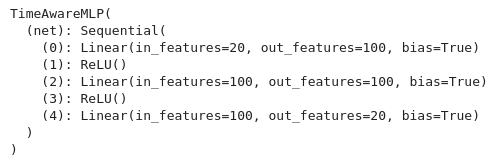

Give it a try!! Our NN accepts tensors of any shape whose last dimension is of size `rec_latent_size`, e.g.,

In [ ]:
input_example = torch.randn(5, 7, rec_latent_size)
input_example.shape

The first argument is a time instant

In [ ]:
out = rec_ode_func(1.2, input_example)
out.shape

The time instant (e.g., $3.14$ below) shouldn't matter at all

In [ ]:
assert torch.allclose(out, rec_ode_func(3.14, input_example))

The above function will determine our solver. For the recognizer we will integrate the differential equation using Euler's method because it's faster than the default (more accurate) *dopri5* and doesn't seem to have any impact on performance (later on, you can go back here and try *dopri5* to convince yourself).

In [ ]:
rec_solver = ODESolver(rec_ode_func, method='euler')

An `ODESolver` expects as input (see above) an initial value, and a bunch of time instants

In [ ]:
output_example = rec_solver(input_example, t)

Check the dimensions of `out` and make sure you know how they come about. A hint:

In [ ]:
assert output_example.shape == (len(t), ) +  input_example.shape

#### A Recurrent Neural Network

...for *assimilating* the observations. As input, it will take the observation (of size 1) and the current *state*. For us, the latter will be the mean and standard deviation of the latent state, hence **twice** `rec_latent_size`. Use [*PyTorch*'s GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). When instantiating the class, set `batch_first` to `True`.

In [ ]:
# your code (~1 LOC)
# rnn = 

Make sure you got it right. Take a look at the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) to understand how PyTorch interprets every dimension for both the *input* and the *hidden state*.

In [ ]:
input_example = torch.randn(5, 3, 1)
hidden_state_sample = torch.randn(1, 5, 2*rec_latent_size)

output, next_state = rnn(input_example, hidden_state_sample)

Let us make sure the dimensions of both tensors returned by the GRU,  `output` and `next_state` have the expected size

In [ ]:
assert torch.allclose(output[:, -1, :].unsqueeze(0), next_state) # the output is simply the last state
assert output.shape == (5, 3, 2*rec_latent_size)
assert next_state.shape == (1, 5, 2*rec_latent_size)

#### A MLP for mapping between latent spaces

**For the generator** we will be using a latent space of size

In [ ]:
gen_latent_size = 10

Define a class for a Multilayer Perceptron (MLP) with an input layer of size **twice** `rec_latent_size` (mean and standard deviation of the *recognizer*), an output layer of size **twice** `gen_latent_size` (mean and standard deviation of the *generator*), and a hidden layer with 100 units (followed by a RELU). This can be identified with `g` in the original paper. You already defined a class for an MLP above. You can copy-paste its code down here and modify it as required. Notice, however, that this MLP should **not** receive time as input, but only the latent state of the *recognizer*.

In [ ]:
# your code (~10-20 LOC)
# class AnotherMLP:    
#     def __init__(self):
#         ...
# rec_latent_to_gen_latent = AnotherMLP(...

Give it a try

In [ ]:
input_example = torch.randn(11, 4, 2*rec_latent_size)
output = rec_latent_to_gen_latent(input_example)

In [ ]:
assert output.shape == (11, 4, 2*gen_latent_size)

#### Factoring all the components into a single module

Let us make a new `torch.nn.Module` that combines the above pieces to implement the *recognizer*. 

As **inputs**, it should receive two `torch.Tensor`s:

- the observations, with dimensions *[batch, time, input feature]*, and
- the time axis.

It should **output** 

- the mean, and 
- the standard deviation

of the latent state for the *generator*, both with dimensions *[batch, generator latent feature]*.

In [ ]:
class Recognizer(nn.Module):
    
    def __init__(self, solver: nn.Module, rec_to_gen: nn.Module, rnn: nn.Module):
    
        super().__init__()
        
        self.solver = solver
        self.rec_to_gen = rec_to_gen
        self.rnn = rnn
        
        # your code? you can add any extra code you need/like
    
    def forward(self, obs, time):
        
        # your code (~1 LOC): find out how many examples are in this batch
        # batch_size = 
        
        # your code (~2 LOC): initialize the mean and standard deviation of the latent state (for the recognizer) to all zeros
        # (the prefix `prev_` is because they will act as the "previous" mean and standard deviation in the loop)
        # prev_yi_mean = 
        # prev_yi_std = 
        
        # the time instant associated to the above (made-up) initial state (a "little" earlier than the first actual time instant);
        # this is a hyperparameter
        prev_t = time[0] - 0.01
        
        # let us loop through all the time instants AND observations...
        for i_t, (t, xi) in enumerate(zip(time, obs.transpose(0, 1))):
                
            # the number of intermediate time instants to use for integrating between `prev_t` to `t_i` (at least 2: start and end points)
            n_time_points = max(2, ((t - prev_t) / 0.05).int())

            # your code (~1 LOC): make a tensor with `n_time_points` regularly-spaced points between `prev_t` and `t`
            # time_points = 
            
            assert len(time_points.shape) == 1

            # your code (~1 LOC): exploit the passed in `solver` to compute the latent state at the time instants in `time_points`
            # from the (initial) value `prev_yi_mean`
            # ode_sol = 
            
            assert ode_sol.shape == (n_time_points, batch_size, rec_latent_size)
            
            # we extract the solution at the last time instant, i.e., the latent state at `t`
            yi_mean = ode_sol[-1]
            
            # your code (~1 LOC): concatenate (along the "features dimension") the mean, `yi_mean`, and *previous* standard deviation
            # `prev_yi_std` in order to have a latent state that encompasses both things
            # yi_mean_std
            
            # your code (~1 LOC): use the passed in `rnn` to assimilate the observations into the latent state; notice the GRU returns an output and
            # an *updated state*; we are only interested in the latter; be careful with the dimensions of the inputs expected by the GRU (you
            # will have to do some `unsqueeze`ing):
            # - the `input` must have *time* as 2nd dimension (`dim=1`), and 
            # - `h_0`'s first dimension must be *layer* (we only have 1)
            # _, updated_state = 
            
            # for the sake of convenience, let us get rid of the time dimension (it should have size 1)
            updated_state = updated_state.squeeze(dim=0)
            
            assert updated_state.shape == (batch_size, 2*rec_latent_size)
            
            # your code (~1 LOC): break down (across the last dimension) the *updated* latent state into mean and standard deviation for the next iteration
            # prev_yi_mean, prev_yi_std = 
            
            assert prev_yi_mean.shape == prev_yi_std.shape == (batch_size, rec_latent_size)
            
            # the current time instant becomes the previous one
            prev_t = t
        
        # at this point all observations have been processed
        
        # notice that the above *updated* state contains the mean and standard deviation of the latent state for the recognizer
        mean_std_y = updated_state
        
        # your code (~1 LOC): use the passed in `rec_to_gen` NN to map the latent state of the recognizer to that of the generator
        # mean_std_z0 = 
        
        assert mean_std_z0.shape[-1] == 2 * gen_latent_size
        
        # your code (~1 LOC): break down (along the "features dimension") `mean_std_z0` into mean and standard deviation
        # mean_z0, std_z0 = 

        # let us enforce a non-negative standard deviation
        std_z0 = std_z0.abs()

        return mean_z0, std_z0

In [ ]:
rec = Recognizer(rec_solver, rec_latent_to_gen_latent, rnn)
rec

Let's give it a try by generating some fake data...

In [ ]:
obs_example = torch.rand(batch_size, 6, 1)
time_example = torch.linspace(0, 1, 6)

...and passing it to our new `torch.nn.Module`

In [ ]:
z0_mean_example, z0_std_example = rec(obs_example, time_example)
assert z0_mean_example.shape == z0_std_example.shape == (batch_size, gen_latent_size)

### Generator

For every example, the *generator* will draw a few samples from the mean and standard deviation computed by the *recognizer*, and use another ODE solver to *push* forward each one of them to get a prediction at the requested time instants. It consists of 3 interconnected `torch.nn.Module`s:

-  another (different) *solver* that, in turn, requires
- a NN modeling the derivative of the function to be integrated (the `f`), and
- a linear function (implemented as a `torch.nn.Module`) mapping from the latent space of *generator* to the *data space*.

Let us build each one of these.

#### A solver with its corresponding internal NN

Build another MLP with
- `gen_latent_size` inputs, 
- `gen_latent_size` outputs,
- 2 linear (`nn.Linear`) hidden layers of 100 units each, with
- a *RELU* (`nn.ReLU`) after each one.

Just like before, the NN should expect as input a time instant and a `torch.Tensor`. It operates by **ignoring the time instant** and sending the `torch.Tensor` sequentially across every layer.

In [ ]:
# your code  (~10-20 LOC)
# gen_ode_func = 

Test time:

In [ ]:
input_example = torch.randn(12, 3, gen_latent_size)
assert gen_ode_func(0.1, input_example).shape == (12, 3, gen_latent_size)

An ODE solver is wrapped around the above function

In [ ]:
# your code (~1 LOC)
# gen_solver = 

The dimensions of the output have the same interpretation as before. The line below checks they are what we expect.

In [ ]:
assert gen_solver(input_example, t).shape == (len(t), ) + input_example.shape

#### Map from the latent space to the data space

Let us build a simple linear function with `gen_latent_size` inputs and a single output.

In [ ]:
# your code (~1 LOC)
# gen_to_data = 

Are we getting the right dimensions at the output?

In [ ]:
assert gen_to_data(input_example).shape == input_example.shape[:-1] + (1,)

### Putting it all together

Let us gather all the pieces into a single `torch.nn.Module` so that we simplify the *training loop* exploiting some of PyTorch's functionality.

The plan is:

- We use the above `recognizer` to compute a mean and standard deviation for every example in the batch.

- We draw a few samples from each (assuming a Gaussian distribution)

    - Be careful when drawing samples in a NN since you cannot backpropagate through the sampling process, meaning, you cannot optimize the parameters (e.g., the mean and standard deviation) of a distribution. The workaround, known as the *reparametrization trick*, consists in sampling from a distribution with fixed parameter (e.g., a standard Gaussian), and then *adjust* the samples the get the desired distribution. You don't need to implement this yourself: PyTorch distributions provide an `rsample` method that does exactly this (see the [documentation for the Gaussian](https://pytorch.org/docs/stable/distributions.html#torch.distributions.normal.Normal.rsample)).
    
- We use the ODE solver to push forward each sample, and get a trajectory in the latent space.

- Using `gen_to_data`, we map each trajectory in the latent space to observations onto a trajectory in the *data space*.

We will be drawing this number of samples from each example in the batch (you can play with it)

In [ ]:
n_samples = 3

In [ ]:
class LatentODE(nn.Module):
    
    def __init__(self, recognizer, solver, gen_to_data):
        
        super().__init__()
    
        self.recognizer = recognizer
        self.solver = solver
        self.gen_to_data = gen_to_data
        
        # your code? you can add any extra code you need/like
    
    def forward(
        self, to_predict_at_time: torch.Tensor, observed_data: torch.Tensor, observed_time: torch.Tensor):
        
        # your code (~1 LOC): exploit the `recognizer` to process the observations (time and data); recall that the
        # implemented recognizer returns both the mean and standard deviation of "z0"
        # z0_mu, z0_std = 
        
        # a standard deviation equal to zero is a problem
        z0_std = z0_std + 1e-6
        
        # your code (~1 LOC): draw some samples from a Gaussian distribution
        # z0_samples = 
        
        # your code (~1 LOC): use the `solver` to "push forward" the initial state (in the latent space)
        # trajectories = 
        
        # your code (~1 LOC): use `gen_to_data` to map from the generator's latent space to the data space
        # predictions = 
        
        return predictions, z0_mu, z0_std

Let us instantiate our model

In [ ]:
model = LatentODE(rec, gen_solver, gen_to_data)
model

For testing we can compute the output for the batch we set above

In [ ]:
batch.keys()

In [ ]:
batch_size

In [ ]:
pred, z0_mu, z0_std = model(batch['to_predict_at_time'], batch['observed_data'], batch['observed_time'])
assert pred.shape == (len(time)//2, n_samples, batch_size, 1)
assert z0_mu.shape == z0_std.shape == (batch_size, gen_latent_size)

## Training

Since we are not setting the *seeds* of the pseudo-random number generators that are being used behind the scenes (*numpy* and *PyTorch*'s), every time we run the notebook we will get different results (parameters are initialized randomly, data is generated randomly) . It shouldn't be a problem: the above model should be quite robust *almost* always find a nice fit. It's a good thing that you experiment a little bit with this to get a sense of the *variance* inherent to the training of NN model.

Some hyperparameters

In [ ]:
lr = 1e-2
n_epochs = 100
wait_until_kl_inc = 10

We'll be using some code from the repository

In [ ]:
from uc3m_ml_healthcare import train

An optimizer and a companion scheduler with a *1cycle* learning rate policy

In [ ]:
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=n_epochs)

A loss function. You can check the check [source code](https://manuvazquez.github.io/uc3m_ml_healthcare/train.html#latentodeloss) if you are interested in all the details.

In [ ]:
z0_prior = torch.distributions.Normal(torch.tensor(0.), torch.tensor(1.))
obsrv_std = torch.tensor(0.01)
loss_function = train.LatentODELoss(noise_std=obsrv_std, prior=z0_prior)

A function encapulating every operation required to process a single batch (regardless of whether it is training or validation)

In [ ]:
def process_batch(model: nn.Module, batch: dict, kl_coef: float) -> tuple:
    
    # `model` is used to evaluate the input
    pred_x, z0_mu, z0_std = model(batch['to_predict_at_time'], batch['observed_data'], batch['observed_time'])

    to_be_predicted_mask = torch.tensor(True)

    return loss_function(pred_x, z0_mu, z0_std, batch['to_predict_data'], to_be_predicted_mask, kl_weight=kl_coef)

Let's train!! Some *bumps* are expected along the way...pay them no mind.

In [ ]:
%%time
for epoch in range(n_epochs):

    for train_batch in train_dataloader:

        optimizer.zero_grad()

        # if the number of epochs is BELOW `wait_until_kl_inc`...
        if epoch < wait_until_kl_inc:

            # ...the KL divergence is ignored in the loss
            kl_coef = 0.

        # if the number of epochs is ABOVE `wait_until_kl_inc`...
        else:

            # ...the weight of KL divergence is adjusted
            kl_coef = (1-0.99** (epoch - wait_until_kl_inc))
        
        loss, _ = process_batch(model, train_batch, kl_coef)

        # backpropagation
        loss.backward()

        # parameters are adjusted
        optimizer.step()
        scheduler.step()
        
    # ================ validation
    
    # evaluation "mode"
    model.eval()
        
    with torch.no_grad():
        
        overall_valid_losses = []
        overall_valid_mses = []

        for valid_batch in valid_dataloader:

            valid_loss, valid_info = process_batch(model, valid_batch, kl_coef)
            
            overall_valid_losses.append(valid_loss.item())
            overall_valid_mses.append(valid_info["mse"].item())
            
        print(f'epoch #{epoch}: loss={np.mean(overall_valid_losses)} | mse={np.mean(overall_valid_mses)}')
        
    # training "mode"
    model.train()

## Plotting

Let us visualize some predictions for the last batch (any will do).

We start by constructing a *finer* time axis in the prediction interval. Notice that we can request predictions in as many time instants as we like (here 120).

In [ ]:
t_pred = torch.linspace(valid_batch['to_predict_at_time'][0], valid_batch['to_predict_at_time'][-1], steps=120)
t_pred.shape

We call the `model` to get the predictions in the above interval. The dimensions of the predictions are *[time, trial, batch, input feature]*

In [ ]:
model.eval()
predictions, *_ = model(t_pred, valid_batch['observed_data'], valid_batch['observed_time'])
predictions.shape

The mean (across samples) of the predictions

In [ ]:
predictions_mean = predictions.mean(dim=1)

We rearrange the above tensor

In [ ]:
y_pred = predictions_mean.squeeze(dim=-1).detach().numpy().T
y_pred.shape

The *observed* and *to-be-predicted*  data in the batch are concatenated together.

In [ ]:
t_batch = torch.concat((valid_batch['observed_time'], valid_batch['to_predict_at_time'])).detach().numpy()
y_batch = torch.concat((valid_batch['observed_data'], valid_batch['to_predict_data']), dim=1)[...,0].cpu().detach().numpy()

Let us plot only 3 time series (dots) along with the corresponding predicted trajectory in the *unseen* part of the time axis

In [ ]:
sns.set_theme()
fig , axis = plt.subplots()
for i, color in zip(range(3), sns.color_palette()):
    sns.scatterplot(x=t_batch, y=y_batch[i], color=color)
    sns.lineplot(x=t_pred, y=y_pred[i], ax=axis, color=color)
axis.set(xlabel='t', ylabel='observations');

In [ ]:
fig.savefig('predictions.pdf')

# Experiments

Try each one of the following experiments and **write down** your observations (what's the effect?)

- Draw more samples of $z_0$ in the latent space of the recognizer (right now we are only drawing 3). 

- Use lower-dimensional latent spaces. Try, for instance, size 4 for the *recognizer* and size 2 for the *generator*.

- Use a different (*fixed*) initialization for the *recognizer*'s latent space (`ones` for instance).

- Remove the *regularization* based on KL divergence.

- Modify the above code so that every ODE solver uses the *adjoint method* to compute gradients.